# EfficientNetB2 Starter for Brain Comp
This is an EfficientNetB2 starter notebook for Kaggle's brain comp. We use only spectrogram features. (The model does not use eeg features yet). This EfficientNet Starter achieves CV 0.72 and LB 0.56! This is +0.10 better than my CatBoost starter. My CatBoost starter is [here][1] (with discussion [here][3]) and achieves CV 0.82 and LB 0.67. 

Both my EfficientNetB2 starter and CatBoost starter use my Kaggle dataset [here][2]. This dataset is a single file which contains all of Kaggle's 11,138 spectrogram parquets. Reading this single file and much faster than reading 11k separate files. If you find my EfficientNetB2 starter notebook helpful, don't forget to upvote my Kaggle [dataset][2] too! 😀 Thanks!

### Train and Infer Tips

This notebook can be used both to train and submit (infer) to Kaggle LB. When training, set variable `LOAD_MODELS_FROM = None` and then new models are trained. After training models, save them to a Kaggle dataset. Then run this notebook a second time with `LOAD_MODELS_FROM = [Path to Kaggle dataset]`. We submit this second notebook to Kaggle LB and it will be quick because it will load models and only infer instead of both training and inferring.

Version 1 of this notebook trains the models (and takes 1 hour). Version 2 of this notebook loads the saved models from version 1 and submits to Kaggle LB (and runs quickly).

[1]: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-67
[2]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
[3]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467576

# Initialize 2xT4 GPUs
We will use both Kaggle T4 GPUs and we will use mixed precision.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

VER = 1

# IF THIS EQUALS NONE, THEN WE TRAIN NEW MODELS
# IF THIS EQUALS DISK PATH, THEN WE LOAD PREVIOUSLY TRAINED MODELS
LOAD_MODELS_FROM = '/kaggle/input/brain-efficientnetb2-models-v1/'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version = 2.13.0
Using 2 GPUs


In [2]:
# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


# Load Train Data

In [3]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# Create Non-Overlapping Eeg Id Train Data
The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [4]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# Read Train Spectrograms 

First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my Kaggle dataset, set variable `READ_SPEC_FILES = False`. Don't forget to upvote this helpful [dataset][1] :-)

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms

In [5]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 2.94 s, sys: 5.91 s, total: 8.86 s
Wall time: 1min 16s


# Train DataLoader
This dataloader outputs 4 spectrogram images as a 4 channel image of size 128x256x4 per train sample. This notebook version is not using data augmention but the code is available below to experiment with albumentations data augmention. Just add `augment = True` when creating the train data loader. And consider adding new transformations to the augment function below.

In [6]:
import albumentations as albu
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, mode='train',
                 specs = spectrograms): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = False
        self.mode = mode
        self.specs = specs
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X = self.__augment_batch(X) 
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        
        X = np.zeros((len(indexes),128,256,4),dtype='float32')
        y = np.zeros((len(indexes)),dtype='int32')
        img = np.ones((128,256),dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test': 
                r = 0
            elif self.mode=='valid': 
                r = int( (row['min'] + row['max'])//4 )
            else:
                # RANDOM CROPS FOR TRAIN
                r = np.random.randint(row['min'], row['max']+1)//2  

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img,np.exp(-4),np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img-m)/(s+ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j,14:-14,:,k] = img[:,22:-22]
                
            if self.mode!='test':
                y[j] = TARS[row.target]
            
        return X,y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

# Display DataLoader
Below we display example dataloader spectrogram images.

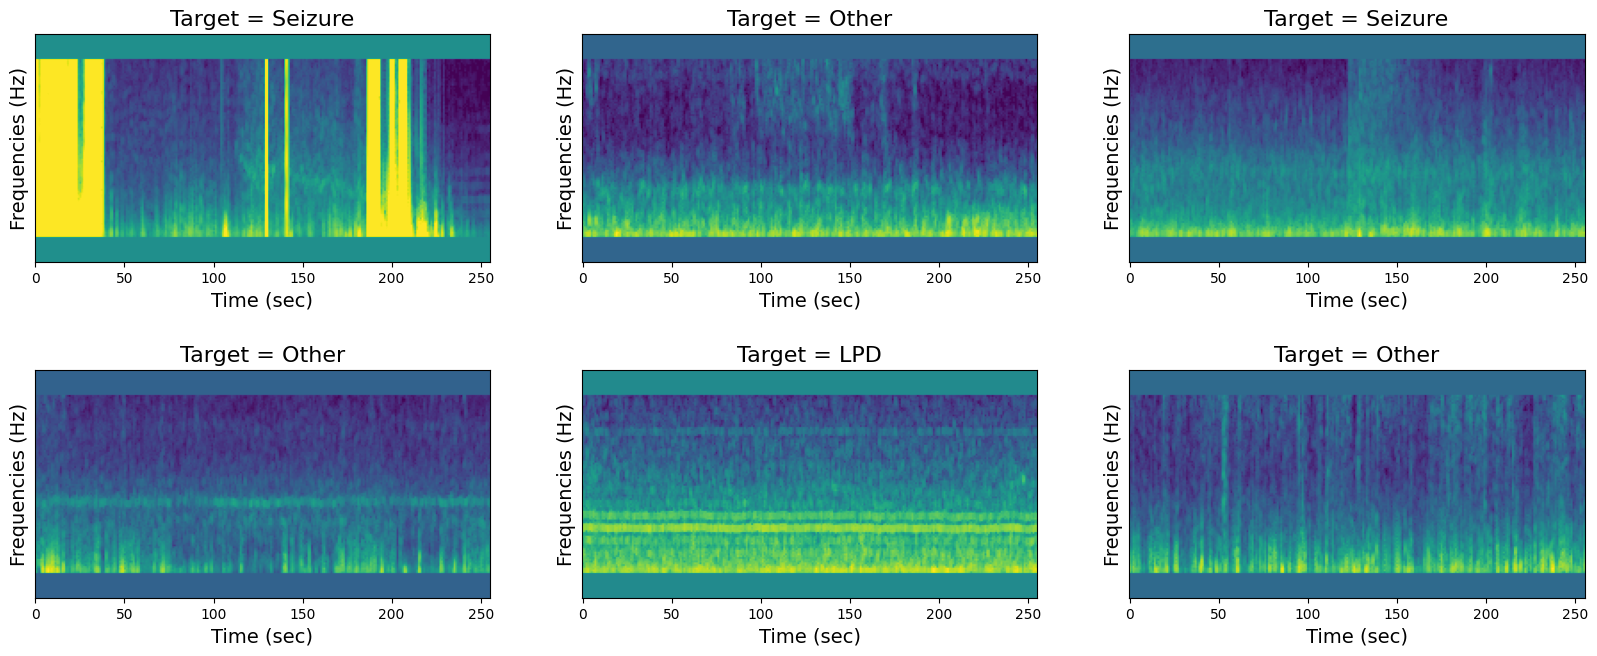

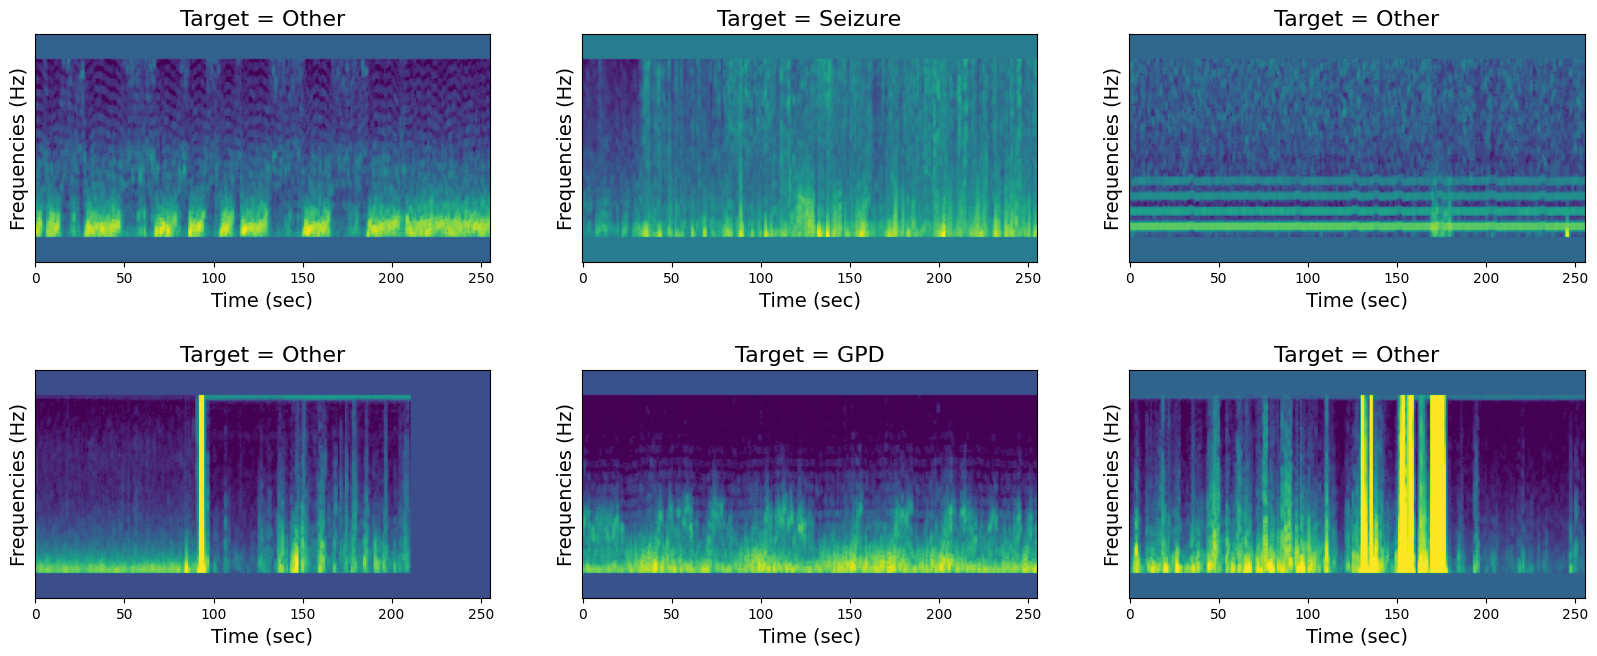

In [7]:
gen = DataGenerator(train, shuffle=True)
ROWS=2; COLS=3; BATCHES=2

for i,(x,y) in enumerate(gen):
    plt.figure(figsize=(20,8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS,COLS,j*COLS+k+1)
            t = y[j*COLS+k]
            img = x[j*COLS+k,:,:,0][::-1,]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            plt.title(f'Target = {TARS2[t]}',size=16)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=14)
    plt.show()
    if i==BATCHES-1: break

# Train Scheduler
We will train our model with a Step Train Schedule for 3 epochs. First 2 epochs are LR=1e-3. Then we step down by 1/10. We train the last epoch with LR=1e-4.

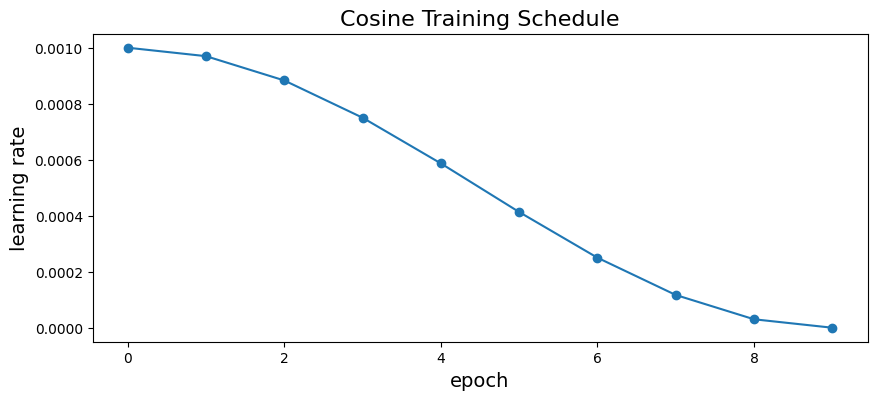

In [8]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS2 = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS2)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Cosine Training Schedule',size=16); plt.show()

LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

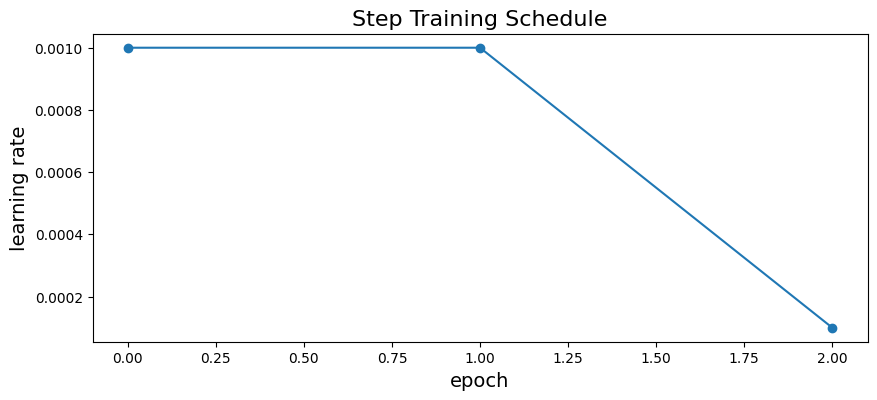

In [9]:
LR_START = 1e-4
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.1
EVERY = 2
EPOCHS = 3

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//EVERY)
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# Build EfficientNetB2 Model

In [10]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
Processing /kaggle/input/tf-efficientnet-whl-files/Keras_Applications-1.0.8-py3-none-any.whl (from efficientnet==1.1.1)


In [11]:
import efficientnet.tfkeras as efn

def build_model():
    
    inp = tf.keras.Input(shape=(128,256,4))
    base_model = efn.EfficientNetB2(include_top=False, weights=None, input_shape=None)
    base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    
    # RESHAPE INPUT 128x256x4 => 512x256x3 MONOTONE IMAGE
    x0 = inp[:,:,:,:1]
    x1 = inp[:,:,:,1:2]
    x2 = inp[:,:,:,2:3]
    x3 = inp[:,:,:,3:4]
    x = tf.keras.layers.Concatenate(axis=1)([x0,x1,x2,x3])
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])
    
    # OUTPUT
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(loss=loss, optimizer = opt) 
        
    return model

# Train Model
We train using Group KFold on patient id. If `LOAD_MODELS_FROM = None`, then we will train new models in this notebook version. Otherwise we will load saved models from the path `LOAD_MODELS_FROM`.

In [12]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [LR])
        model.save_weights(f'EB2_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EB2_v{VER}_f{i}.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    del model, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
54/54 [==============================] - 23s 290ms/step
#########################
### Fold 2
### train size 13671, valid size 3418
#########################
54/54 [==============================] - 22s 308ms/step
#########################
### Fold 3
### train size 13671, valid size 3418
#########################
54/54 [==============================] - 22s 309ms/step
#########################
### Fold 4
### train size 13671, valid size 3418
#########################
54/54 [==============================] - 22s 312ms/step
#########################
### Fold 5
### train size 13672, valid size 3417
#########################
54/54 [==============================] - 22s 323ms/step


# CV Score for EfficientNetB2
This is CV score for our EfficientNet model.

In [13]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)

CV Score KL-Div for EfficientNetB2 = 0.7344206480309698


# Infer Test and Create Submission CSV
Below we use our 5 EfficientNet fold models to infer the test data and create a `submission.csv` file.

In [14]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [15]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values
    
# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

In [16]:
# INFER EFFICIENTNET ON TEST
preds = []
model = build_model()
test_gen = DataGenerator(test, shuffle=False, batch_size=64, mode='test', specs = spectrograms2)

for i in range(5):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EB2_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'EB2_v{VER}_f{i}.h5')
    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 2s 2s/step
Fold 2
1/1 [==============================] - 0s 45ms/step
Fold 3
1/1 [==============================] - 0s 48ms/step
Fold 4
1/1 [==============================] - 0s 60ms/step
Fold 5
1/1 [==============================] - 0s 44ms/step

Test preds shape (1, 6)


In [17]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.220678,0.120944,0.001214,0.22684,0.027411,0.402913


In [18]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32